# Catalyst classification tutorial

## Requirements

Download and install the latest version of catalyst and other libraries required for this tutorial.

In [1]:
!pip install -U catalyst
!pip install albumentations
!pip install pretrainedmodels

     |████████████████████████████████| 348kB 9.5MB/s 
     |████████████████████████████████| 460kB 71.5MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 204kB 56.8MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


     |████████████████████████████████| 634kB 9.0MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=815e3fc0584b4185bbe1691a143596eeaa7d3b36db6f3adeac74b97d53fac45c
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=ac1dffe8715957d6b3dd89fdee552200537a74330c355c462cfeeec3189e9833
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


### Colab extras

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `"Python 3"` and `"GPU"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run` all and watch the tutorial.


To intergate visualization library `plotly` to colab, run

In [0]:
import IPython

def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

## Setting up GPUs
PyTorch and Catalyst versions:

In [3]:
import torch, catalyst

torch.__version__, catalyst.__version__

('1.4.0', '20.01.3')

You can also specify GPU/CPU usage for this turorial.

Available GPUs

In [4]:
from catalyst.utils import get_available_gpus

get_available_gpus()

[0]

In [5]:
import os
from typing import List, Tuple, Callable

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

---

## Reproducibility first

Catalyst provides a special utils for research results reproducibility. <br/>
For example, `catalyst.utils.set_global_seed` fixes seed for all main DL frameworks (` PyTorch`, `Tensorflow`,` random` and `numpy`)

In case of CuDNN you can set deterministic mode and flag to use benchmark with
`catalyst.utils.prepare_cudnn`.

In [6]:
SEED = 42
from catalyst.utils import set_global_seed, prepare_cudnn

set_global_seed(SEED)
prepare_cudnn(deterministic=True)

## Dataset

In this tutorial we will use one of four datasets:

- [Ants / Bees dataset](https://www.dropbox.com/s/ffzfpbwzwdo9qp8/ants_bees_cleared_190806.tar.gz )
- [Stanford Dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) 
- [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition)
- [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

If you are on MacOS and you don’t have `wget`, you can install it with:` brew install wget`.

In [7]:
def load_data(dataset: str) -> None:
    """
    script downloads the data archive and moves it to "Images" folder
    Args:
        dataset (str): dataset name
    """
    if dataset is None:
        return
    
    !rm -rf Images/
    if dataset == "ants_bees":
        !wget https://www.dropbox.com/s/8aiufmo0yyq3cf3/ants_bees_cleared_190806.tar.gz
        !tar -xf ants_bees_cleared_190806.tar.gz &>/dev/null
        !mv ants_bees_cleared_190806 Images
    elif dataset == "flowers":
        # https://www.kaggle.com/alxmamaev/flowers-recognition
        !wget https://www.dropbox.com/s/lwcvy4eb68drvs3/flowers.tar.gz
        !tar -xf flowers.tar.gz &>/dev/null
        !mv flowers Images
    elif dataset == "dogs":
        # https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
        !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
        !tar -xf images.tar &>/dev/null
    elif dataset == "artworks":
        # https://www.kaggle.com/ikarus777/best-artworks-of-all-time
        !wget https://www.dropbox.com/s/ln4ot1fu2sgtgvg/artworks.tar.gz
        !tar -xf artworks.tar.gz &>/dev/null
        !mv artworks Images
    else:
        raise Exception(f"Got unknown dataset '{dataset}'")

Let's specify the dataset by `DATASET` variable:
- `ants_bees` (~ 400 pictures for 2 classes)  – for CPU experiments
- `flowers` (~ 4k pictures for 5 classes)     – for fast GPU experiments 
- `dogs` (~ 20k pictures for 120 classes)
- `artworks` (~ 8k pictures for 50 classes)   – for GPU experiments

In [8]:
DATASET = "flowers" # "ants_bees" / "flowers" / "dogs" / "artworks"

In [9]:
load_data(dataset=DATASET)

--2020-02-04 09:44:49--  https://www.dropbox.com/s/lwcvy4eb68drvs3/flowers.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lwcvy4eb68drvs3/flowers.tar.gz [following]
--2020-02-04 09:44:49--  https://www.dropbox.com/s/raw/lwcvy4eb68drvs3/flowers.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3ea8ce2303d4d1ab0c35b9b28.dl.dropboxusercontent.com/cd/0/inline/AxfuAXVY7x3Cnvggbj0G9BQKFWTjk-S0jr4ZgQPw9GYT87dTwgjxwqYMFh-CeyyU4dNA7HpmAhK1kzNAszuqSiR-mUycRLFXSe8gwvvceWswqrf56H7-3uhsBwWTitr_77Q/file# [following]
--2020-02-04 09:44:49--  https://uca3ea8ce2303d4d1ab0c35b9b28.dl.dropboxusercontent.com/cd/0/inline/AxfuAXVY7x3Cnvggbj0G9BQKFWTjk-S0jr4ZgQPw9GYT87dTwgjxwqYMFh-CeyyU4dNA7HpmAhK1kzNAszuqSiR-mUycRLFXSe8gwvvce

In [10]:
from pathlib import Path

ROOT = "Images/"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 4323


Let's check out the data!

In [11]:
from catalyst.utils import imread
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

You can restart the cell below to see more examples.

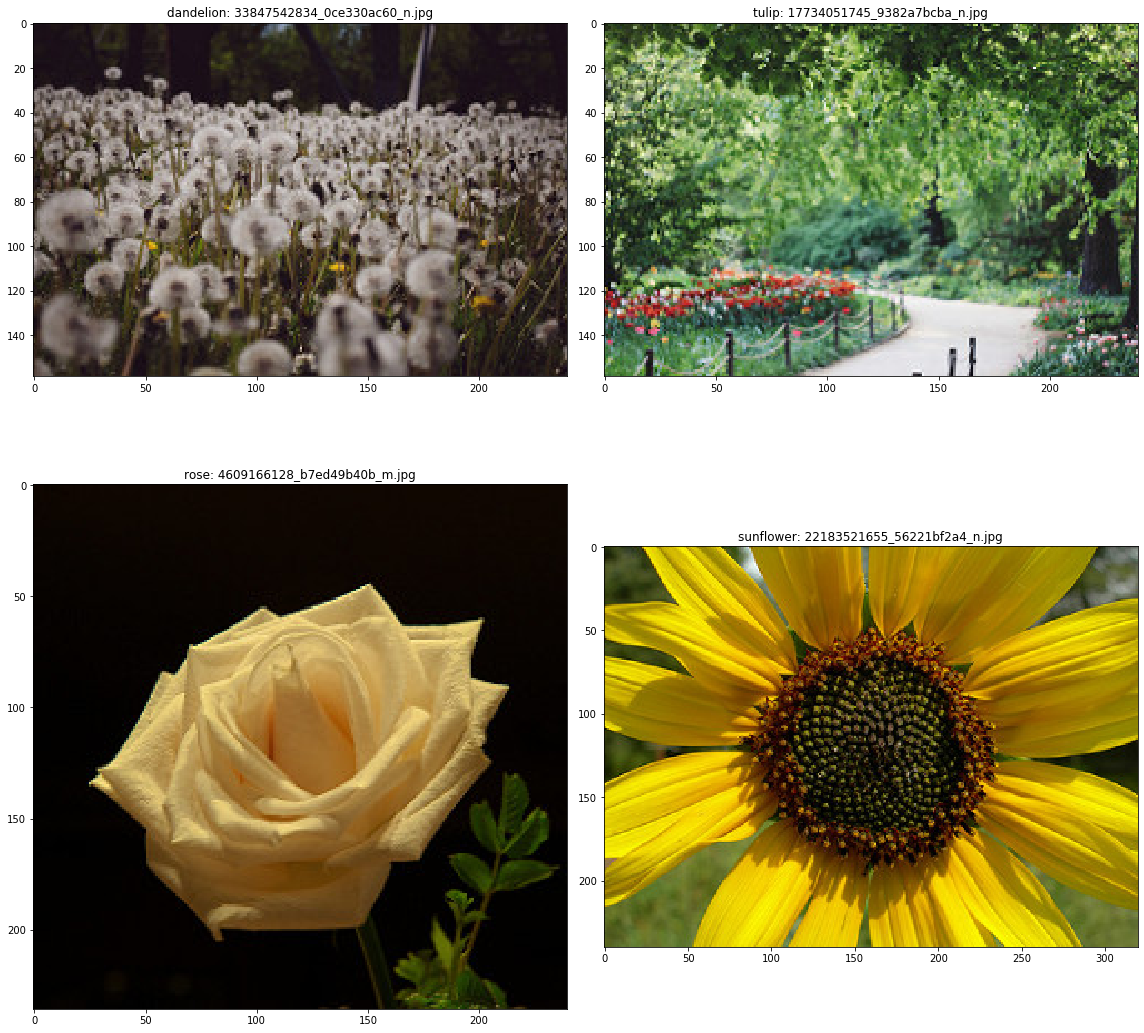

In [12]:
images = read_random_images(ALL_IMAGES)
show_examples(images)

## Dataset preprocessing

With Catalyst we can easily create a dataset from the following folder structure:
```
dataset/
    class_1/
        *.ext
        ...
    class_2/
        *.ext
        ...
    ...
    class_N/
        *.ext
        ...
```

`create_dataset` function goes through a given directory and creates a dictionary `Dict[class_name, List[image]]`

In [15]:
from catalyst.utils import create_dataset, create_dataframe, get_dataset_labeling

dataset = create_dataset(dirs=f"{ROOT}/*", extension="*.jpg")

and `create_dataframe` function creates typical `pandas.DataFrame` for further analysis

In [16]:
df = create_dataframe(dataset, columns=["class", "filepath"])
df.head()

class                                   filepath
0  daisy    Images/daisy/100080576_f52e8ee070_n.jpg
1  daisy    Images/daisy/10140303196_b88d3d6cec.jpg
2  daisy  Images/daisy/10172379554_b296050f82_n.jpg
3  daisy    Images/daisy/10172567486_2748826a8b.jpg
4  daisy  Images/daisy/10172636503_21bededa75_n.jpg

In [17]:
len(df)

4323

finally `prepare_dataset_labeling` creates a numerical label for each unique class name

In [18]:
tag_to_label = get_dataset_labeling(df, "class")
tag_to_label

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Let's add a column with a numerical label value to the DataFrame. 
It can be easily done with `map_dataframe` function.

In [19]:
from catalyst.utils.pandas import map_dataframe

df_with_labels = map_dataframe(df, tag_column="class", class_column="label", tag2class=tag_to_label, verbose=True)
df_with_labels.head()

class                                   filepath  label
0  daisy    Images/daisy/100080576_f52e8ee070_n.jpg      0
1  daisy    Images/daisy/10140303196_b88d3d6cec.jpg      0
2  daisy  Images/daisy/10172379554_b296050f82_n.jpg      0
3  daisy    Images/daisy/10172567486_2748826a8b.jpg      0
4  daisy  Images/daisy/10172636503_21bededa75_n.jpg      0

additionaly let's save the `class_names` for further usage

In [20]:
class_names = [name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])]
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Now let's divide our dataset into the `train` and` valid` parts. 

The parameters for the split_dataframe function are the same as [sklearn.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split). 

We also define `test_size` (it is optional) and `random_state` for reproducibility.

In [25]:
from catalyst.utils import split_dataframe_train_test

train_data, valid_data = split_dataframe_train_test(df_with_labels, test_size=0.2, random_state=SEED)
train_data, valid_data = train_data.to_dict('records'), valid_data.to_dict('records')

In [26]:
len(train_data), len(valid_data)

(3458, 865)

## Augmentations

In order to save your time during data preparation/reading/writing, Catalyst provides a special abstraction – [Reader](https://catalyst-team.github.io/catalyst/api/data.html#reader). <br/> 
Reader allows you to read various structures, for example, images, strings, numerical values and perform some functions on top of them.

In [28]:
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from functools import partial

import torch

num_classes = len(tag_to_label)

# ReaderCompose collects different Readers into one pipeline
open_fn = ReaderCompose([
    
    # Reads images from the `rootpath` folder using the key `input_key =" filepath "` (here should be the filename)
    # and writes it to the output dictionary by `output_key="features"` key
    ImageReader(
        input_key="filepath",
        output_key="features",
        rootpath=ROOT
    ),
    
    # Reads a number from our dataframe by the key `input_key =" label "` to np.long
    # and writes it to the output dictionary by `output_key="targets"` key
    ScalarReader(
        input_key="label",
        output_key="targets",
        default_value=-1,
        dtype=np.int64
    ),
    
    # Same as above, but with one encoding
    ScalarReader(
        input_key="label",
        output_key="targets_one_hot",
        default_value=-1,
        dtype=np.int64, 
        one_hot_classes=num_classes
    )
])

For augmentation of our dataset, we will use the [albumentations library](https://github.com/albu/albumentations).  <br/>
You can view the list of available augmentations on the documentation [website](https://albumentations.readthedocs.io/en/latest/api/augmentations.html).

In [29]:
from albumentations import Compose, LongestMaxSize, PadIfNeeded
from albumentations import ShiftScaleRotate, IAAPerspective, RandomBrightnessContrast, RandomGamma, \
    HueSaturationValue, ToGray, CLAHE, JpegCompression

from albumentations import Normalize
from albumentations.torch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        LongestMaxSize(max_size=image_size),
        PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        HueSaturationValue(p=0.3),
        JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [Normalize(), ToTensor()]

def compose(_transforms):
    # combine all augmentations into one single pipeline
    result = Compose([item for sublist in _transforms for item in sublist])
    return result

Like Reader, there is a close abstraction for handling augmentations and key-value-based dataloaders – [Augmentor](https://catalyst-team.github.io/catalyst/api/data.html#augmentor).

In [30]:
from catalyst.data.augmentor import Augmentor
from torchvision import transforms


train_transforms = compose([pre_transforms(), hard_transforms(), post_transforms()])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

# Takes an image from the input dictionary by the key `dict_key` and performs `train_transforms` on it.
train_data_transforms = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: train_transforms(image=x)["image"]
    )
])


# Similarly for the validation part of the dataset. 
# we only perform squaring, normalization and ToTensor
valid_data_transforms = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: valid_transforms(image=x)["image"]
    )
])

Let's look at the augmented results. <br/>
The cell below can be restarted.

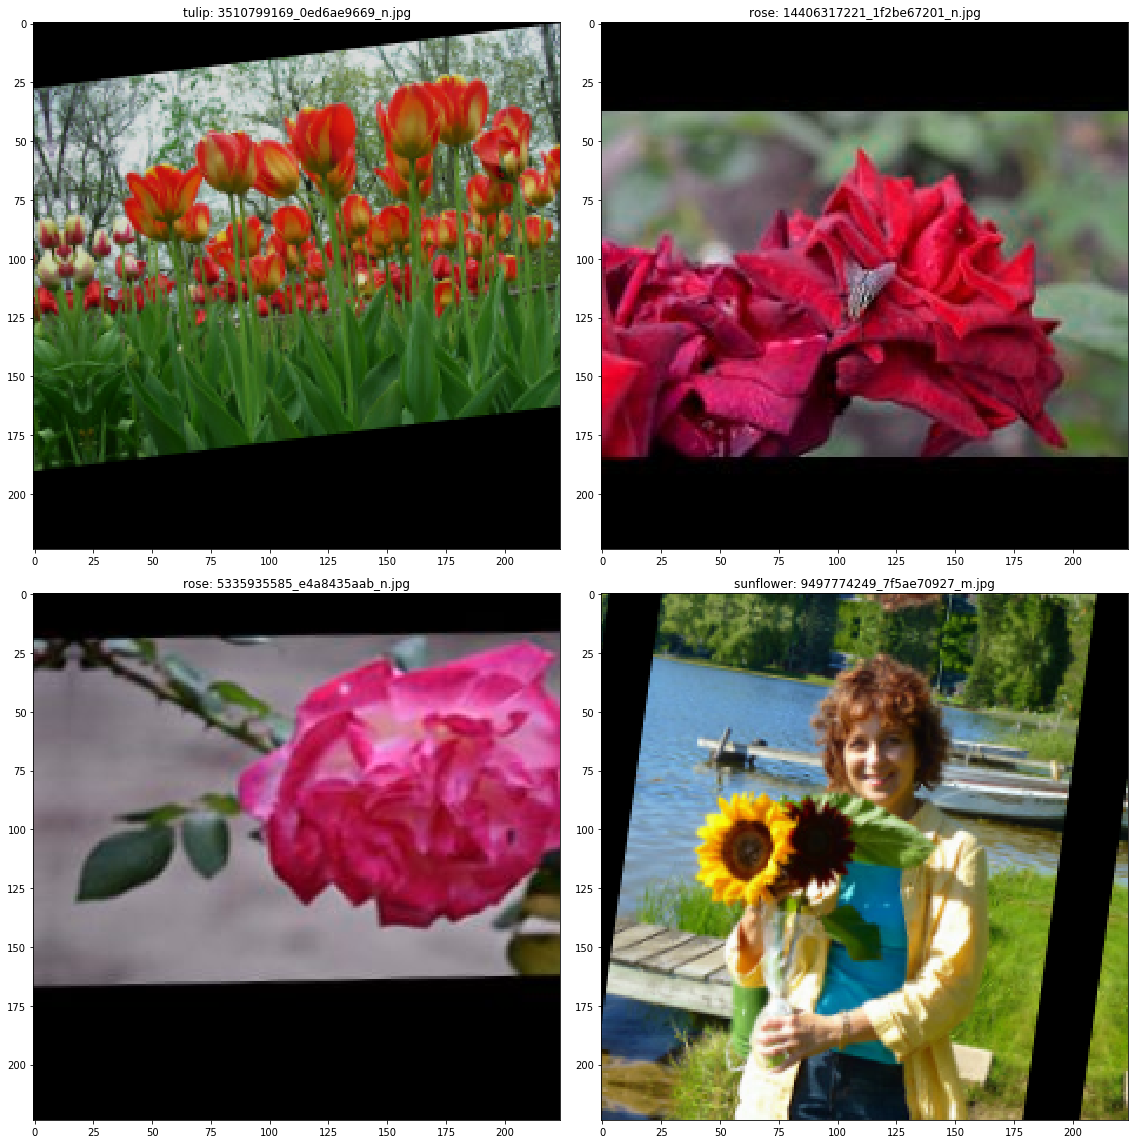

In [31]:
images = read_random_images(ALL_IMAGES)

images = [
    (title, show_transforms(image=i)["image"])
    for (title, i) in images
]
show_examples(images)

## Pytorch dataloaders

Using `catalyst.utils.get_loader`, you can immediately get loaders only from the dataset and data-converting functions.

In [32]:
import collections

batch_size = 64
num_workers = 4

def get_loaders(
    open_fn: Callable,
    train_transforms_fn: transforms.Compose,
    valid_transforms_fn: transforms.Compose,
    batch_size: int = batch_size, 
    num_workers: int = num_workers,
    sampler = None
) -> collections.OrderedDict:
    """
    Args:
        open_fn: Reader for reading data from a dataframe
        train_transforms_fn: Augmentor for train part
        valid_transforms_fn: Augmentor for valid part
        batch_size: batch size
        num_workers: How many subprocesses to use to load data,
        sampler: An object of the torch.utils.data.Sampler class 
            for the dataset data sampling strategy specification
    """
    train_loader = utils.get_loader(
        train_data,
        open_fn=open_fn,
        dict_transform=train_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=sampler is None, # shuffle data only if Sampler is not specified (PyTorch requirement)
        sampler=sampler
    )

    valid_loader = utils.get_loader(
        valid_data,
        open_fn=open_fn,
        dict_transform=valid_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False, 
        sampler=None
    )

    # Catalyst expects an ordered dictionary with train/valid/infer loaders. 
    # The number of loaders can vary.
    # For example, it can easily handle even some complex logic like:
    # loaders["train_dataset1"] = train_loader_1
    # loaders["train_dataset2"] = train_loader_2
    # ....
    # loaders["valid_1"] = valid_loader_1
    # loaders["valid_2"] = valid_loader_2
    # ...
    # loaders["infer_1"] = infer_loader_1
    # loaders["infer_2"] = infer_loader_2
    # ...
    
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

loaders = get_loaders(open_fn, train_data_transforms, valid_data_transforms)

## Model

Let's take the classification model from [Cadene pretrain models](https://github.com/Cadene/pretrained-models.pytorch). This repository contains a huge number of pre-trained PyTorch models. <br/>
But at first, let's check them out!

In [33]:
import pretrainedmodels

pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

For this tutorial purposes, `ResNet18` is good enough, but you can try other models

In [34]:
model_name = "resnet18"

By `pretrained_settings` we can see what the given network expects as input and what would be the expected output.

In [35]:
pretrainedmodels.pretrained_settings[model_name]

{'imagenet': {'input_range': [0, 1],
  'input_size': [3, 224, 224],
  'input_space': 'RGB',
  'mean': [0.485, 0.456, 0.406],
  'num_classes': 1000,
  'std': [0.229, 0.224, 0.225],
  'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth'}}

The model returns logits for classification into 1000 classes from ImageNet. <br/>
Let's define a module that will replace the last fully-connected layer for our model with l2-normalization.

In [36]:
import torch
from torch import nn

class FCWithL2Norm(nn.Module):
    def __init__(self, input_size, embedding_size=256):
        super(FCWithL2Norm, self).__init__()
        self._fc = nn.Linear(input_size, embedding_size)
        self._l2 = lambda x: x / x.norm(2, dim=1, keepdim=True).expand_as(x)

    def forward(self, x):
        x = self._fc(x)
        x = self._l2(x)
        return x

def get_model(model_name: str, embedding_size: int, pretrained: str = "imagenet"):
    model_fn = pretrainedmodels.__dict__[model_name]
    model = model_fn(num_classes=1000, pretrained=pretrained)
    
    dim_feats = model.last_linear.in_features

    # model.last_linear = nn.Linear(input_size, embedding_size)
    model.last_linear = FCWithL2Norm(dim_feats, embedding_size)

    return model

## Model training

In [37]:
# model creation
embedding_size = 256

model = get_model(model_name, embedding_size)

# as we are working on basic classification problem (no multi-class/multi-label)
# let's use standard CE loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[9], gamma=0.3
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


To run some DL experiment, Catalyst uses a [Runner](https://catalyst-team.github.io/catalyst/api/dl.html#catalyst.dl.core.runner.Runner) abstraction. <br/>
It contains main logic about "how" you run the experiment and getting predictions.

For supervised learning case, there is an extention for Runner – [SupervisedRunner](https://catalyst-team.github.io/catalyst/api/dl.html#module-catalyst.dl.runner.supervised), which provides additional methods like `train`, `infer` and `predict_loader`.

In [39]:
from catalyst.contrib.nn import TripletLoss
from catalyst.contrib.dl import KNNMetricCallback
from catalyst.dl.runner import SupervisedRunner
from tqdm.auto import tqdm

runner = SupervisedRunner()

# folder for all the experiment logs
logdir = "./logs/metric_learning_tutorial"
NUM_EPOCHS = 10

runner.train(
    model=model,
    logdir=logdir,
    criterion=TripletLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    # For this task, we will check accuracy, AUC and F1 metrics
    callbacks=[
        KNNMetricCallback(
            num_classes=num_classes,
            class_names=class_names,
            cv_loader_names={
                "train": ["valid"],
            }
        )
    ],
    main_metric="knn",
    minimize_metric=False,
    num_epochs=NUM_EPOCHS,
    verbose=True
)

1/10 * Epoch (train): 100% 55/55 [00:25<00:00,  3.35it/s, loss=0.297]

TypeError: ignored

In [0]:
torch.cuda.empty_cache()

### Training with Focal Loss and OneCycle

In the `catalyst.contrib` there are a large number of different additional criterions, models, layers etc

For example,

[catalyst.contrib.criterion](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.criterion.ce):
- HuberLoss
- CenterLoss
- FocalLossMultiClass
- DiceLoss / BCEDiceLoss
- IoULoss / BCEIoULoss
- LovaszLossBinary / LovaszLossMultiClass / LovaszLossMultiLabel
- WingLoss

Lr scheduler in [catalyst.contrib.schedulers](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.schedulers.base):
- OneCycleLR

Moreover, in [catalyst.contrib.models](https://catalyst-team.github.io/catalyst/api/contrib.html#models) you can find various models for segmentation:
- Unet / ResnetUnet
- Linknet / ResnetLinknet
- FPNUnet / ResnetFPNUnet
- PSPnet / ResnetPSPnet
- MobileUnet


Finally, several handwritten modules in [catalyst.contrib.modules](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.modules.common):
- Flatten
- TemporalAttentionPooling
- LamaPooling
- NoisyLinear
- GlobalAvgPool2d / GlobalMaxPool2d
- GlobalConcatPool2d / GlobalAttnPool2d

a bunch of others


But for now, let's take `FocalLoss` and `OneCycleLR` to play around.

In [0]:
from catalyst.contrib.criterion import FocalLossMultiClass
from catalyst.contrib.schedulers import OneCycleLR

model = get_model(model_name, num_classes)

criterion = FocalLossMultiClass()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = OneCycleLR(
    optimizer, 
    num_steps=NUM_EPOCHS, 
    lr_range=(0.001, 0.0001),
    warmup_steps=1
)

# FocalLoss expects one_hot for the input
# in our Reader function we have already created the conversion of targets in one_hot
# so, all we need - respecify the target key name
runner = SupervisedRunner(input_target_key="targets_one_hot")
logdir = "./logs/classification_tutorial_1"
NUM_EPOCHS = 10

TypeError: ignored

In [0]:
runner.train(
    model=model,
    logdir=logdir,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets_one_hot",
            activation="Softmax"
        )
    ],
    num_epochs=NUM_EPOCHS,
    verbose=True,
)

In [0]:
# it can take a while (colab issue)
utils.plot_metrics(
    logdir=logdir, 
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

In [0]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)

### Training analysis and model predictions 

The `utils.plot_metrics` method reads tensorboard logs from the logdir and plots beautiful metrics with `plotly` package.

In [0]:
# it can take a while (colab issue)
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

The method below will help us look at the predictions of the model for each image.

In [0]:
from torch.nn.functional import softmax

def show_prediction(
    model: torch.nn.Module, 
    class_names: List[str], 
    titles: List[str],
    images: List[np.ndarray],
    device: torch.device
) -> None:
    with torch.no_grad():
        tensor_ = torch.stack([
            valid_transforms(image=image)["image"]
            for image in images
        ]).to(device)
        
        
        logits = model.forward(tensor_)
        probabilities = softmax(logits, dim=1)
        predictions = probabilities.argmax(dim=1)
    
    images_predicted_classes = [
        (f"predicted: {class_names[x]} | correct: {title}", image)
        for x, title, image in zip(predictions, titles, images)
    ]
    show_examples(images_predicted_classes)


In [0]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)

### Balancing classes in the dataset

There are several useful data-sampler implementations in the `catalyst.data.sampler`. For example,
- `BalanceClassSampler` allows you to create stratified sampling on an unbalanced dataset. <br/> A strategy can be either downsampling, upsampling or some prespeficied number of samples per class. <br/> Very important feature for every classification problem.
- `MiniEpochSampler` allows you to split your "very large dataset" and sample some small portion of it every epoch. <br/> This is useful for those cases where you need to check valid metrics and save checkpoints more often. <br/> For example, your 1M images dataset can be sampled in 100k per epoch with all necessary metrics.

In [0]:
from catalyst.data.sampler import BalanceClassSampler

labels = [x["label"] for x in train_data]
sampler = BalanceClassSampler(labels, mode="upsampling")

# let's re-create our loaders with BalanceClassSampler
loader = get_loaders(open_fn, train_data_transforms, valid_data_transforms, sampler=sampler)

model = get_model(model_name, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = OneCycleLR(
    optimizer, 
    num_steps=NUM_EPOCHS, 
    lr_range=(0.001, 0.0001),
    warmup_steps=1
)

runner = SupervisedRunner()
logdir = "./logs/classification_tutorial_2"
NUM_EPOCHS = 10

In [0]:
runner.train(
    model=model,
    logdir=logdir,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets_one_hot",
            activation="Softmax"
        )
    ],
    num_epochs=NUM_EPOCHS,
    verbose=True,
)

In [0]:
# it can take a while (colab issue)
utils.plot_metrics(
    logdir=logdir, 
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

In [0]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)

## Model inference

With SupervisedRunner, you can easily predict entire loader with only one method call.

In [0]:
predictions = runner.predict_loader(
    model, loaders["valid"],
    resume=f"{logdir}/checkpoints/best.pth", verbose=True
)

The resulting object has shape = (number of elements in the loader, output shape from the model)

In [0]:
predictions.shape

Thus, we can obtain probabilities for our classes.

In [0]:
print("logits: ", predictions[0])

In [0]:
probabilities = torch.softmax(torch.from_numpy(predictions[0]), dim=0)
print("probabilities: ", probabilities)

In [0]:
label = probabilities.argmax().item()
print(f"predicted: {class_names[label]}")
